In [1]:
# !pip install tensorflow_probability


In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.sys.path.append('../../../evaluation/')
import pickle
import numpy as np
import pandas as pd
import methods
import metrics
import tensorflow as tf
from scipy.stats import spearmanr

input_path = '../../../data/simulated_2d_demo/'
model_path = './model/'
gmm_path = './predictions_gmm.pkl'


In [12]:
# load data
x_test = pickle.load(open(input_path+'/test/input_data.pkl', 'rb'))
y_test = pickle.load(open(input_path+'/test/target_data.pkl', 'rb'))
y_test = [
    metrics.output_to_stats_2d(i) for i in y_test
]
sizes_test = pickle.load(open(input_path+'/test/sizes.pkl', 'rb'))


In [28]:
# predict NN

os.sys.path.append(model_path)
from predict import extract_features

# load model
model = tf.keras.models.load_model(model_path+'/model_checkpoint', custom_objects={'kl_divergence_loss': kl_divergence_loss})

# extract features
features = np.stack([extract_features(i) for i in data])
features = features[..., np.newaxis]

# predict
p_nn = model.predict(features)


32/32 [==============================] - 0s 4ms/step


In [29]:
# reshape correlations into an upper triangular matrix
n_dimensions = 2
corr_indices = [(i, j) for i in range(n_dimensions) for j in range(i + 1, n_dimensions)]
corr_indices = tf.constant(corr_indices, dtype=tf.int64)
def output_to_stats(batch_vectors, n_dimensions):
    """ Converts a batch of arrays each consisting of means, std devs, and pairwise correlations
        to separate arrays of mean vectors and covariance matrices
    """
    batch_size = tf.shape(batch_vectors)[0]
    # number of unique correlations in the upper triangular part
    num_correlations = (n_dimensions* (n_dimensions- 1)) // 2
    # extract statistics
    means = batch_vectors[:, :n_dimensions]
    std_devs = batch_vectors[:, n_dimensions:(n_dimensions*2)]
    correlations = batch_vectors[:, (n_dimensions*2):]
    # expand indices for batch
    batch_indices = tf.reshape(tf.range(batch_size, dtype=tf.int64), (-1, 1, 1))
    batch_indices = tf.tile(batch_indices, (1, tf.shape(corr_indices)[0], 1))
    expanded_indices = tf.concat([batch_indices, tf.tile(tf.expand_dims(corr_indices, 0), (batch_size, 1, 1))], axis=-1)
    # scatter correlations into the upper triangular part
    upper_triangular = tf.scatter_nd(expanded_indices, correlations, shape=(batch_size, n_dimensions, n_dimensions))
    upper_triangular = upper_triangular + tf.transpose(upper_triangular, perm=[0, 2, 1]) - tf.linalg.diag(tf.linalg.diag_part(upper_triangular))
    correlation_matrix = tf.linalg.set_diag(upper_triangular, tf.ones((batch_size, n_dimensions), dtype=batch_vectors.dtype))
    # compute the covariance matrix
    std_devs = tf.expand_dims(std_devs, axis=-1)  # shape (batch_size, n_dimensions, 1)
    covariance_matrices = correlation_matrix * (std_devs @ tf.transpose(std_devs, perm=[0, 2, 1]))
    return means, covariance_matrices

p_nn = output_to_stats(p_nn, n_dimensions)


In [30]:
p_nn

(array([[ 0.0115543 , -0.01395014],
        [ 0.0115543 , -0.01395014],
        [ 0.0115543 , -0.01395014],
        ...,
        [ 0.0115543 , -0.01395014],
        [ 0.0115543 , -0.01395014],
        [ 0.0115543 , -0.01395014]], dtype=float32),
 <tf.Tensor: shape=(1000, 2, 2), dtype=float32, numpy=
 array([[[2.9700580e-01, 4.8685987e-03],
         [4.8685987e-03, 2.8217025e-04]],
 
        [[2.9700580e-01, 4.8685987e-03],
         [4.8685987e-03, 2.8217025e-04]],
 
        [[2.9700580e-01, 4.8685987e-03],
         [4.8685987e-03, 2.8217025e-04]],
 
        ...,
 
        [[2.9700580e-01, 4.8685987e-03],
         [4.8685987e-03, 2.8217025e-04]],
 
        [[2.9700580e-01, 4.8685987e-03],
         [4.8685987e-03, 2.8217025e-04]],
 
        [[2.9700580e-01, 4.8685987e-03],
         [4.8685987e-03, 2.8217025e-04]]], dtype=float32)>)

In [31]:
p_nn = [(i,j) for i,j in zip(p_nn[0], p_nn[1])]


In [32]:
# compute error
errors_nn = metrics.get_errors(targets, p_nn)

In [33]:
def get_error_statistics(errors):
    df = pd.DataFrame({
        'mean_bd': [np.nanmean(i) for i in errors.values()],
        'median_bd': [np.quantile(i, 0.5) for i in errors.values()],
        'acc_bd_0.01': [len(np.where(i<=0.01)[0])/len(i) for i in errors.values()],
        'acc_bd_0.025': [len(np.where(i<=0.025)[0])/len(i) for i in errors.values()],
        'acc_bd_0.05': [len(np.where(i<=0.05)[0])/len(i) for i in errors.values()],
    })
    return df


In [34]:
errors = {
    'GMM': errors_gmm,
    'NN': errors_nn
}

df = get_error_statistics(errors)
df.index = errors.keys()
df


,mean_bd,median_bd,acc_bd_0.01,acc_bd_0.025,acc_bd_0.05
GMM,0.023414,0.007042,0.605,0.772,0.877
NN,1.614176,1.617326,0.000,0.000,0.000


In [35]:
with open('./errors.pkl', 'wb') as f:
    pickle.dump(errors, f)
    

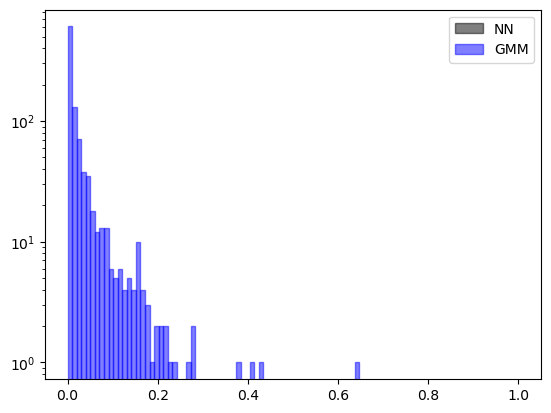

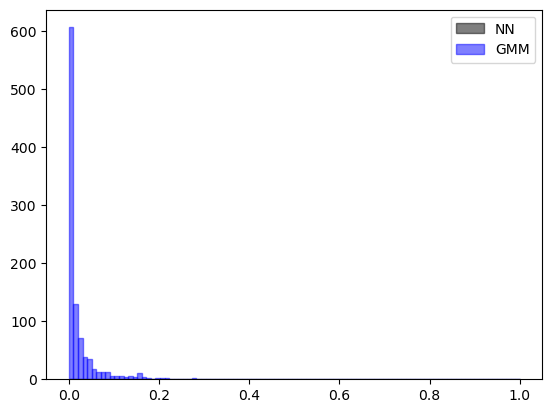

In [36]:
import matplotlib.pyplot as plt

plt.hist(errors['NN'], np.linspace(0, 1.0, 100), edgecolor='k', color='k', alpha=0.5, label='NN');
plt.hist(errors['GMM'], np.linspace(0, 1.0, 100), edgecolor='b', color='b', alpha=0.5, label='GMM');
plt.yscale('log')
plt.legend();

plt.figure()
plt.hist(errors['NN'], np.linspace(0, 1, 100), edgecolor='k', color='k', alpha=0.5, label='NN');
plt.hist(errors['GMM'], np.linspace(0, 1, 100), edgecolor='b', color='b', alpha=0.5, label='GMM');
plt.legend();


In [15]:
means = pickle.load(open(data_path+'/means.pkl', 'rb'))
stds = pickle.load(open(data_path+'/stds.pkl', 'rb'))
sizes = pickle.load(open(data_path+'/sizes.pkl', 'rb'))
corr_mats = pickle.load(open(data_path+'/corr_mats.pkl', 'rb'))


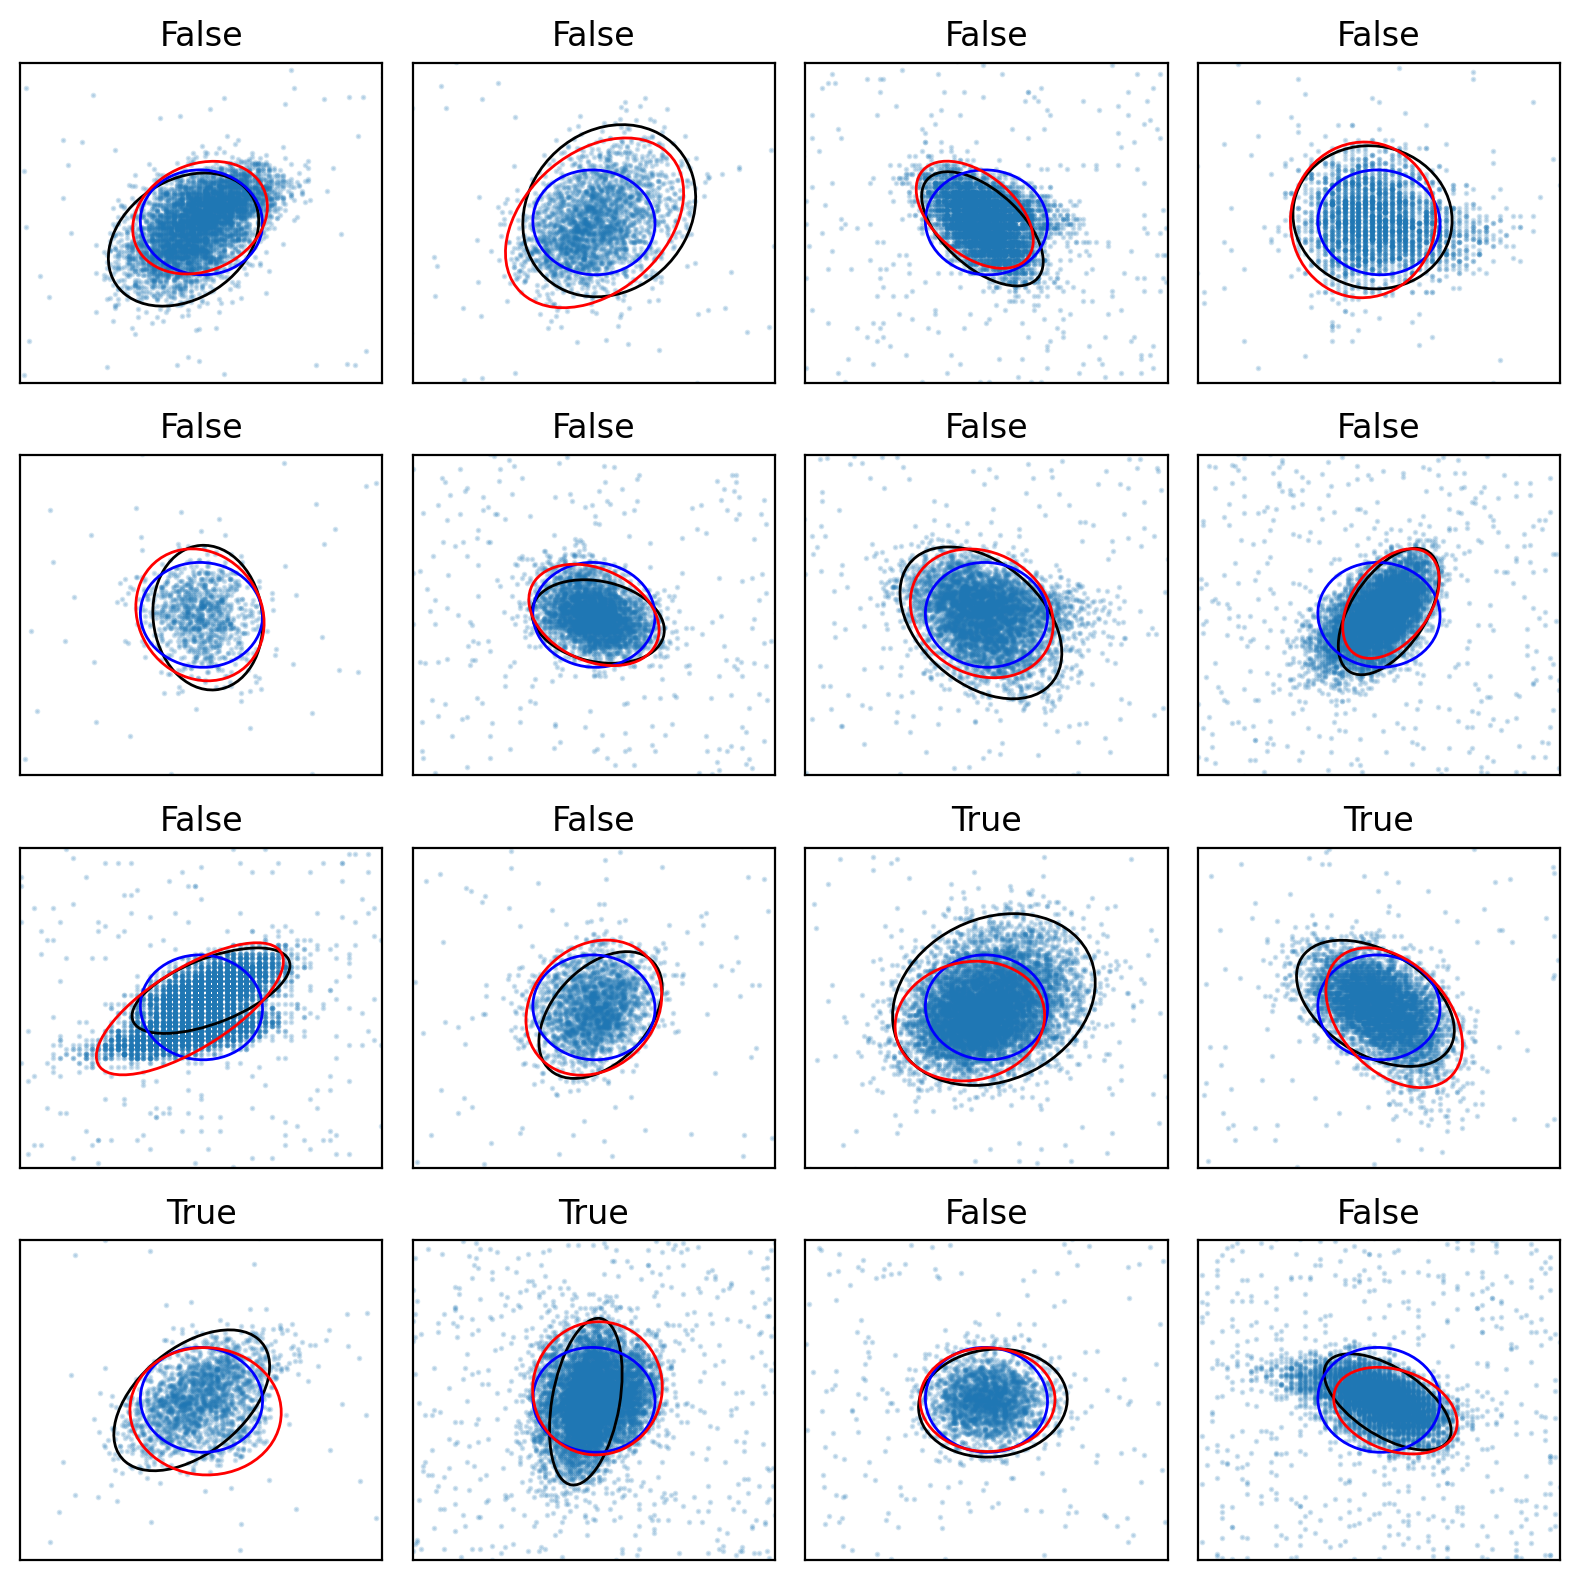

In [16]:
# check examples

predictions = {
    'GMM': p_gmm,
    'NN': p_nn
}

nr = 4
nc = 4

# get examples above or below an error threshold
example_error_score = 0.01
example_error_method = 'GMM'
idx = np.random.choice(np.where((errors[example_error_method]>=example_error_score))[0], nr*nc)

# # or random choice
# idx = np.random.choice(len(errors['NN']), nr*nc)

x_range = np.linspace(-4, 4, 41)

plt.figure(figsize=(8,8), dpi=200)

# sizes = pickle.load(open(data_path+'/sizes.pkl', 'rb'))
# ref_fracs = [i[0]/sum(i) for i in sizes]

for i in range(nr*nc):
    
    plt.subplot(nr, nc, i+1)
    
    plt.scatter(data[idx[i]][:,0], data[idx[i]][:,1], s=1, alpha=0.2)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

    # target
    ell = metrics.plot_cov_ellipse(targets[idx[i]][0].squeeze(), targets[idx[i]][1], edgecolor='k', fc='none')
    plt.gca().add_patch(ell)
    
    # nn
    ell = metrics.plot_cov_ellipse(predictions['NN'][idx[i]][0].squeeze(), predictions['NN'][idx[i]][1], edgecolor='b', fc='none')
    plt.gca().add_patch(ell)
    
    # gmm
    ell = metrics.plot_cov_ellipse(predictions['GMM'][idx[i]][0].squeeze(), predictions['GMM'][idx[i]][1], edgecolor='r', fc='none')
    plt.gca().add_patch(ell)
    
    plt.title(f'{errors["NN"][idx[i]]<errors["GMM"][idx[i]]}')
    
plt.tight_layout()
    

In [17]:
ref_frac = [i[0]/sum(i) for i in sizes]
total_sizes = [sum(i) for i in sizes]
bd_dists = []
for i in range(len(data)):
    if len(sizes[i])-1==2:
        bd_dists.append(
            metrics.bhattacharyya_gaussian_distance(
                np.array(means[i][0]),
                metrics.correlation_to_covariance(corr_mats[i][0], stds[i][0]),
                np.array(means[i][1]),
                metrics.correlation_to_covariance(corr_mats[i][1], stds[i][1])
            )
        )
    else:
        bd_dists.append(
            np.mean([
                metrics.bhattacharyya_gaussian_distance(
                    np.array(means[i][0]),
                    metrics.correlation_to_covariance(corr_mats[i][0], stds[i][0]),
                    np.array(means[i][1]),
                    metrics.correlation_to_covariance(corr_mats[i][1], stds[i][1])
                ),
                metrics.bhattacharyya_gaussian_distance(
                    np.array(means[i][0]),
                    metrics.correlation_to_covariance(corr_mats[i][0], stds[i][0]),
                    np.array(means[i][2]),
                    metrics.correlation_to_covariance(corr_mats[i][2], stds[i][2])
                )
            ])
        )

pd.DataFrame({
    'method': ['GMM', 'NN'],
    'ref_frac': [spearmanr(errors['GMM'], ref_frac), spearmanr(errors['NN'], ref_frac)],
    'sample_size': [spearmanr(errors['GMM'], total_sizes), spearmanr(errors['NN'], total_sizes)],
    'distance': [spearmanr(errors['GMM'], bd_dists), spearmanr(errors['NN'], bd_dists)]
})



,method,ref_frac,sample_size,distance
0,GMM,"(-0.4688390242455414, 8.663532965887328e-56)","(-0.04123945643562827, 0.1925647308255837)","(0.05487143487143488, 0.08286068069535243)"
1,NN,"(-0.2025893391971072, 1.0090880955629739e-10)","(-0.009893621140217482, 0.7546756738440344)","(0.34630444630444635, 1.4947341572126033e-29)"


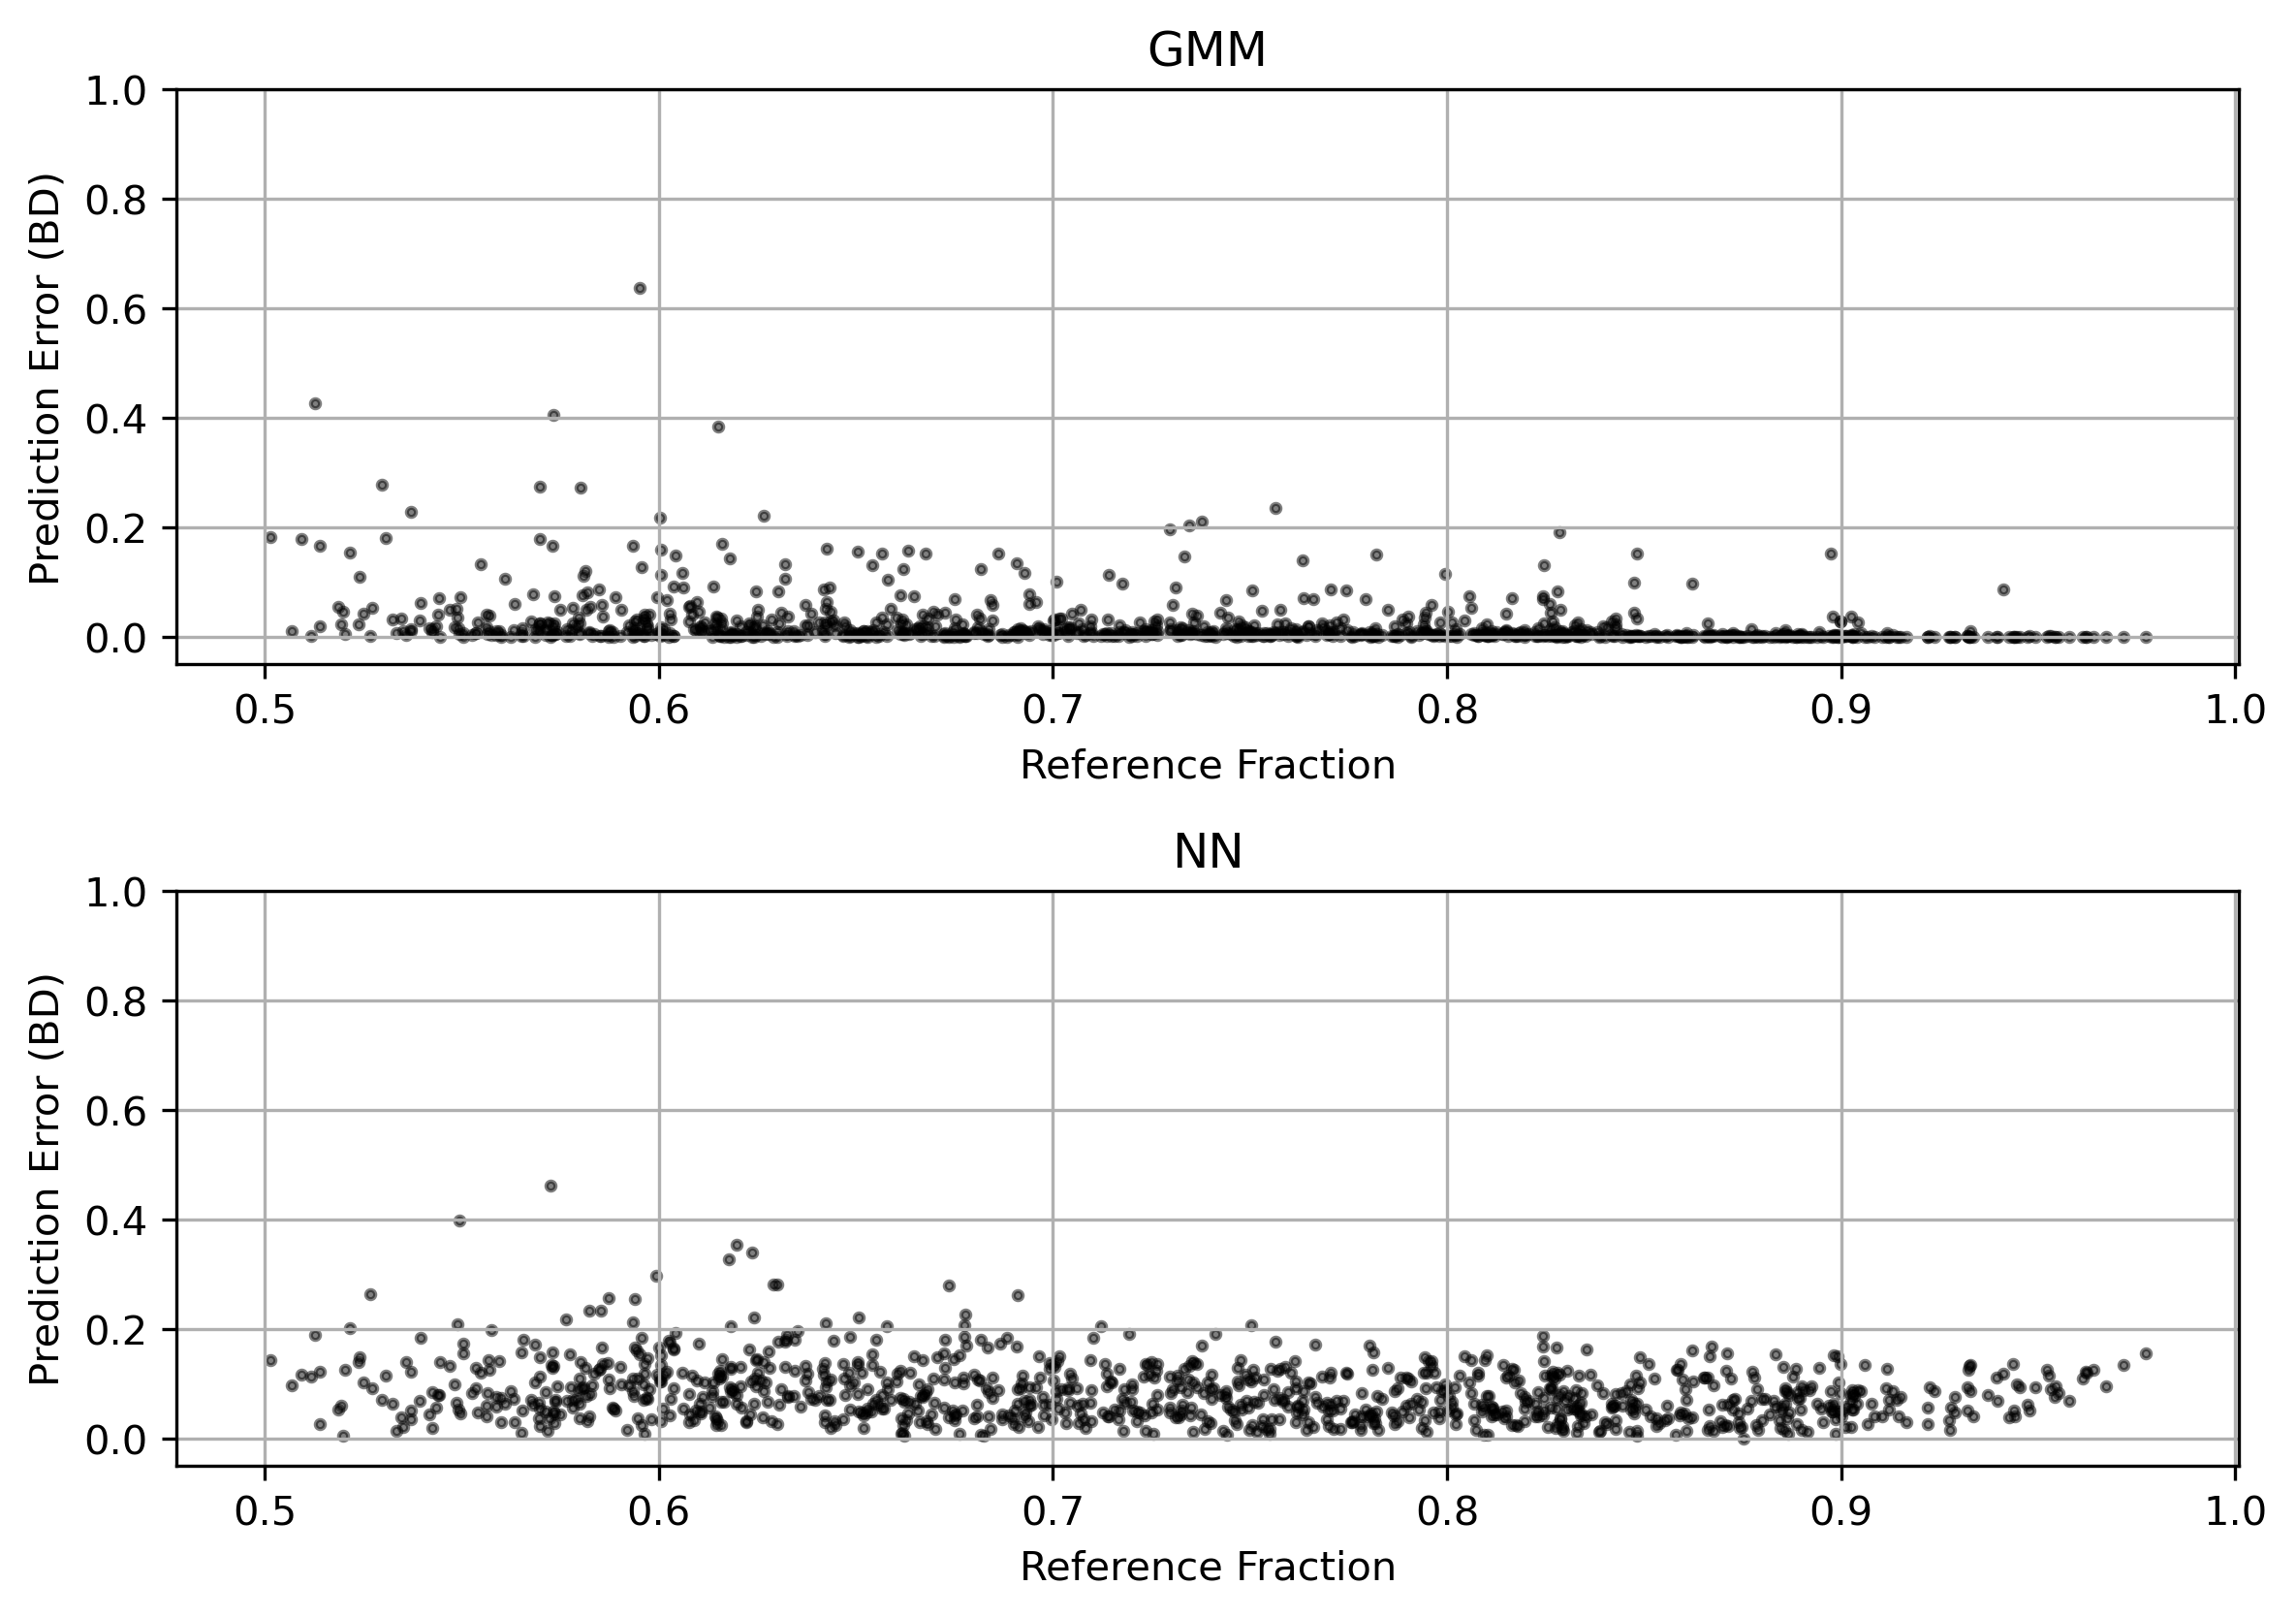

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=300)
for c,i in enumerate(['GMM', 'NN']):
    plt.subplot(3,1,c+1)
    plt.scatter(ref_frac, errors[i], s=5, c='k', alpha=0.5)
    plt.ylim([-0.05, 1.0])
    if i=='GMM':
        plt.title('GMM')
    else:
        plt.title(i)
    plt.grid()
    plt.ylabel('Prediction Error (BD)')
    plt.xlabel('Reference Fraction')
plt.tight_layout()

    

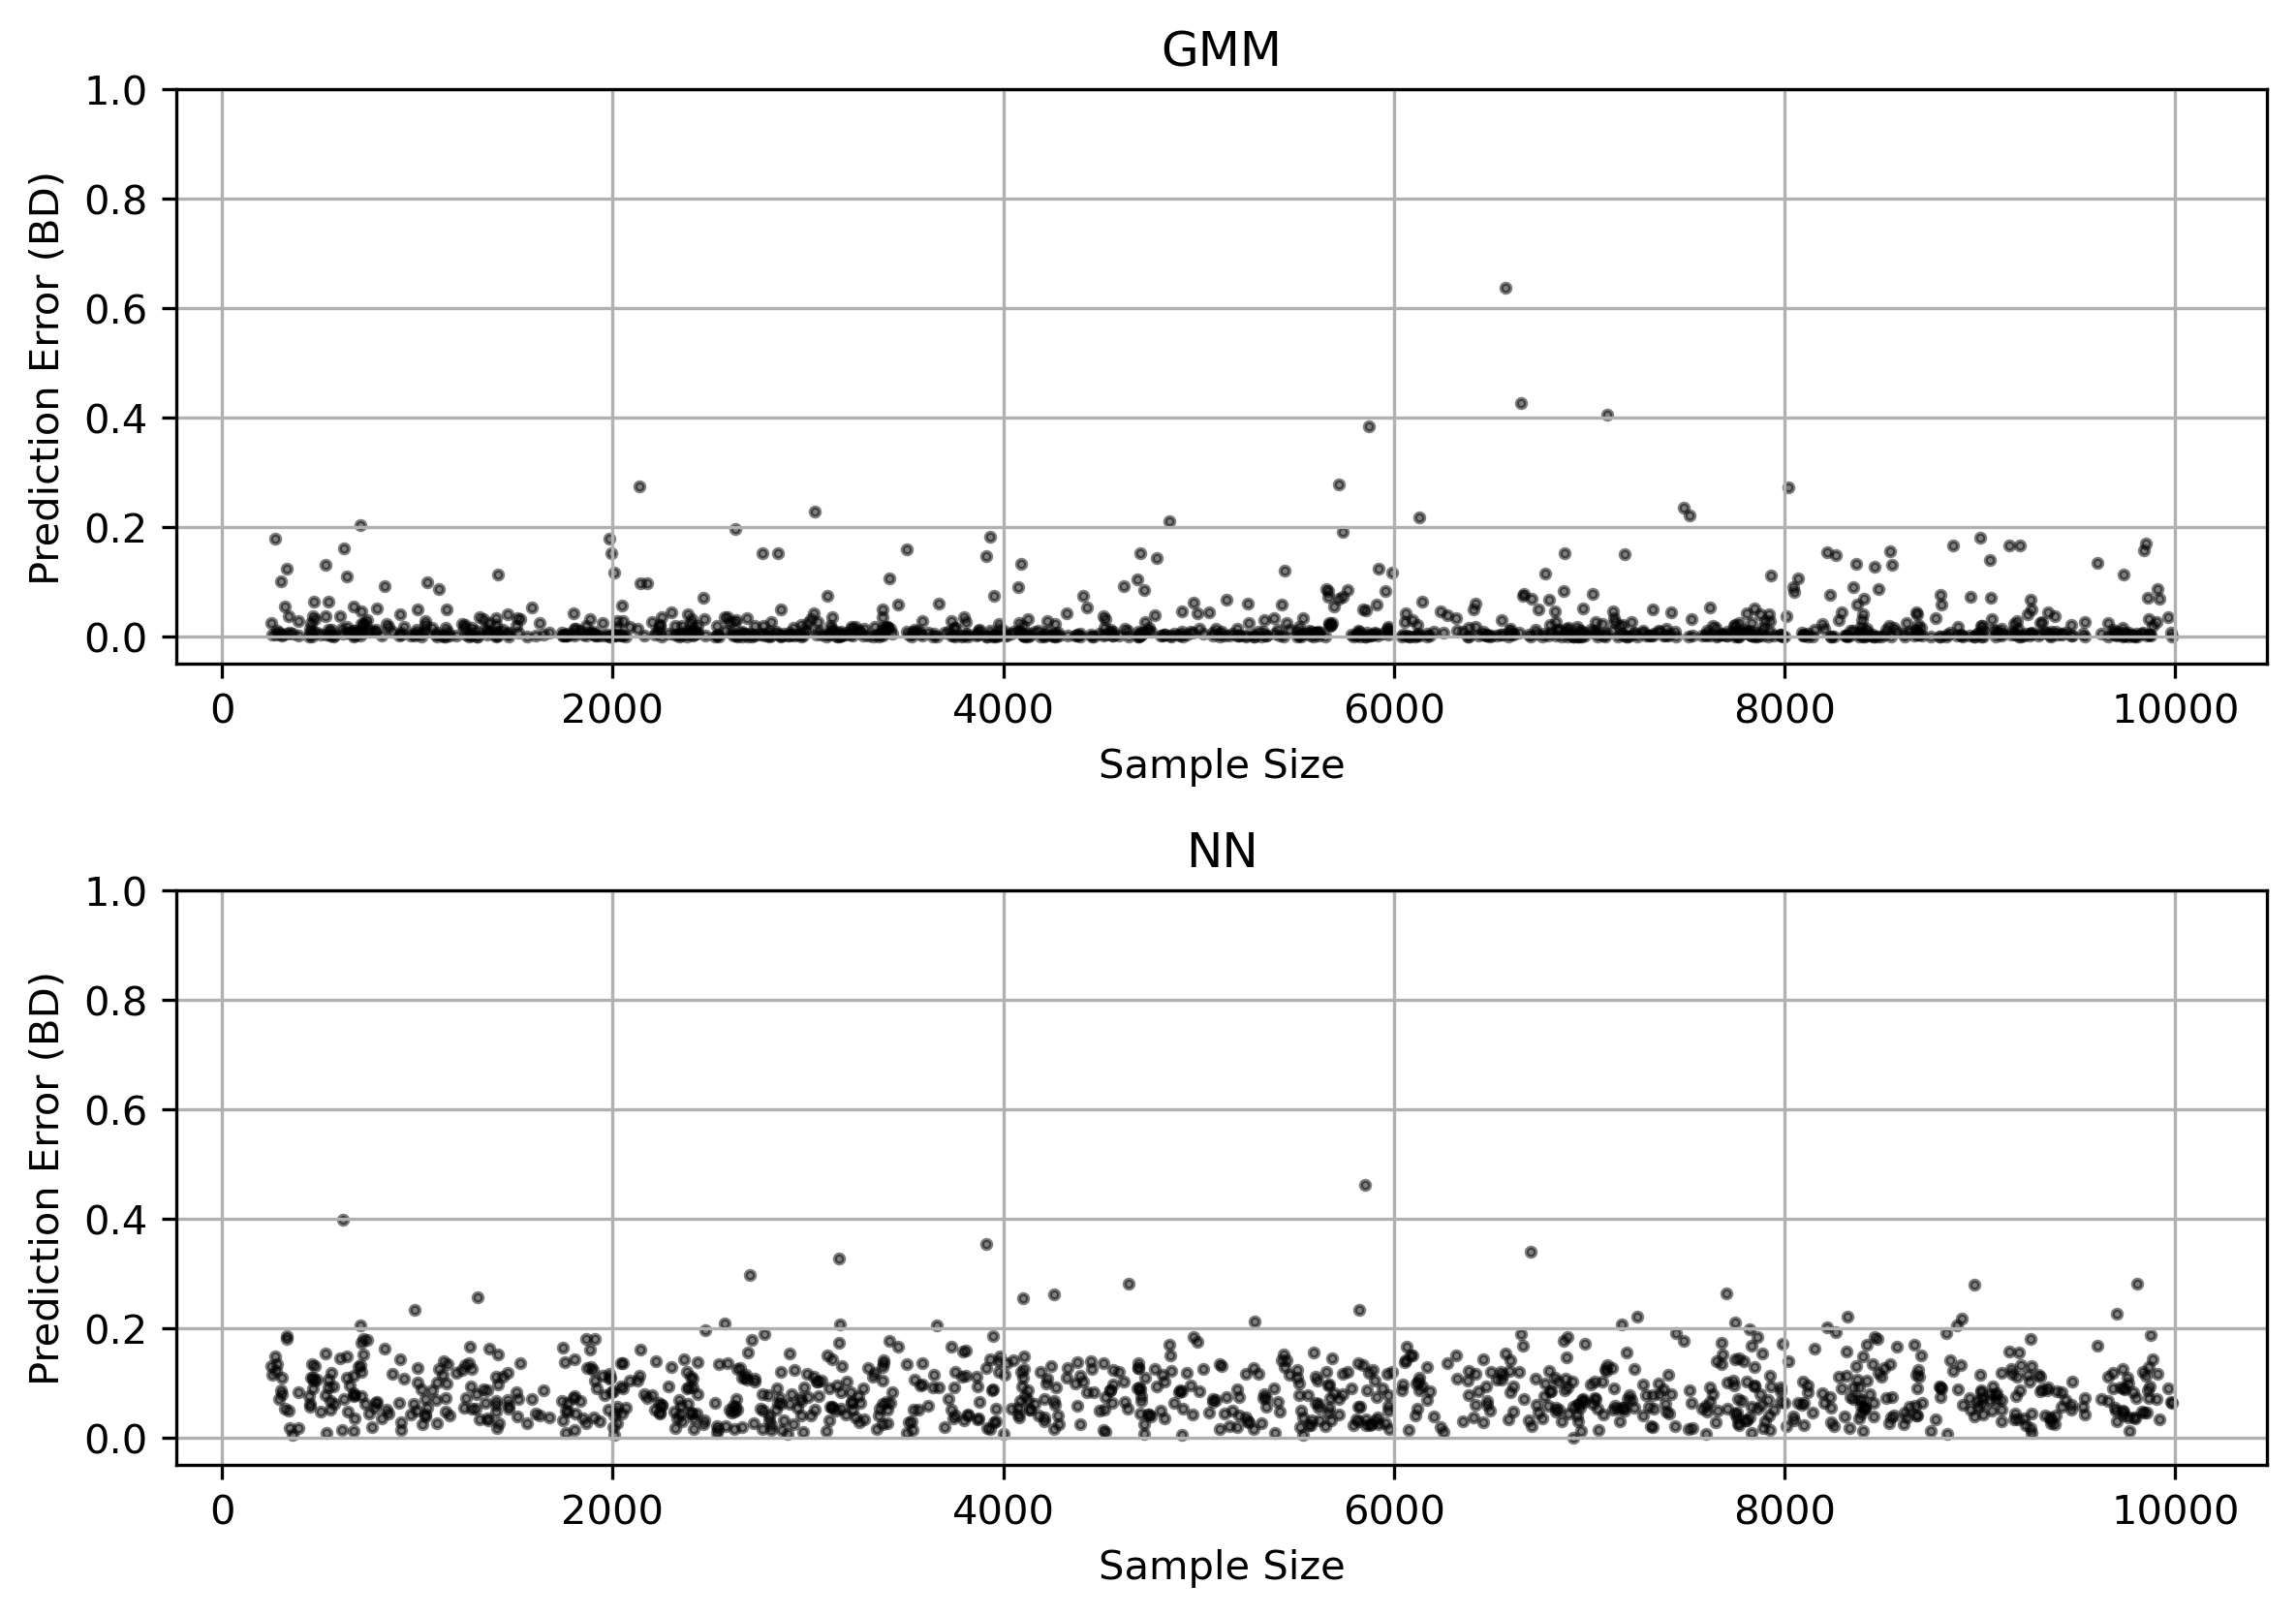

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=300)
for c,i in enumerate(['GMM', 'NN']):
    plt.subplot(3,1,c+1)
    plt.scatter(total_sizes, errors[i], s=5, c='k', alpha=0.5)
    plt.ylim([-0.05, 1.0])
    if i=='GMM':
        plt.title('GMM')
    else:
        plt.title(i)
    plt.grid()
    plt.ylabel('Prediction Error (BD)')
    plt.xlabel('Sample Size')
plt.tight_layout()

    

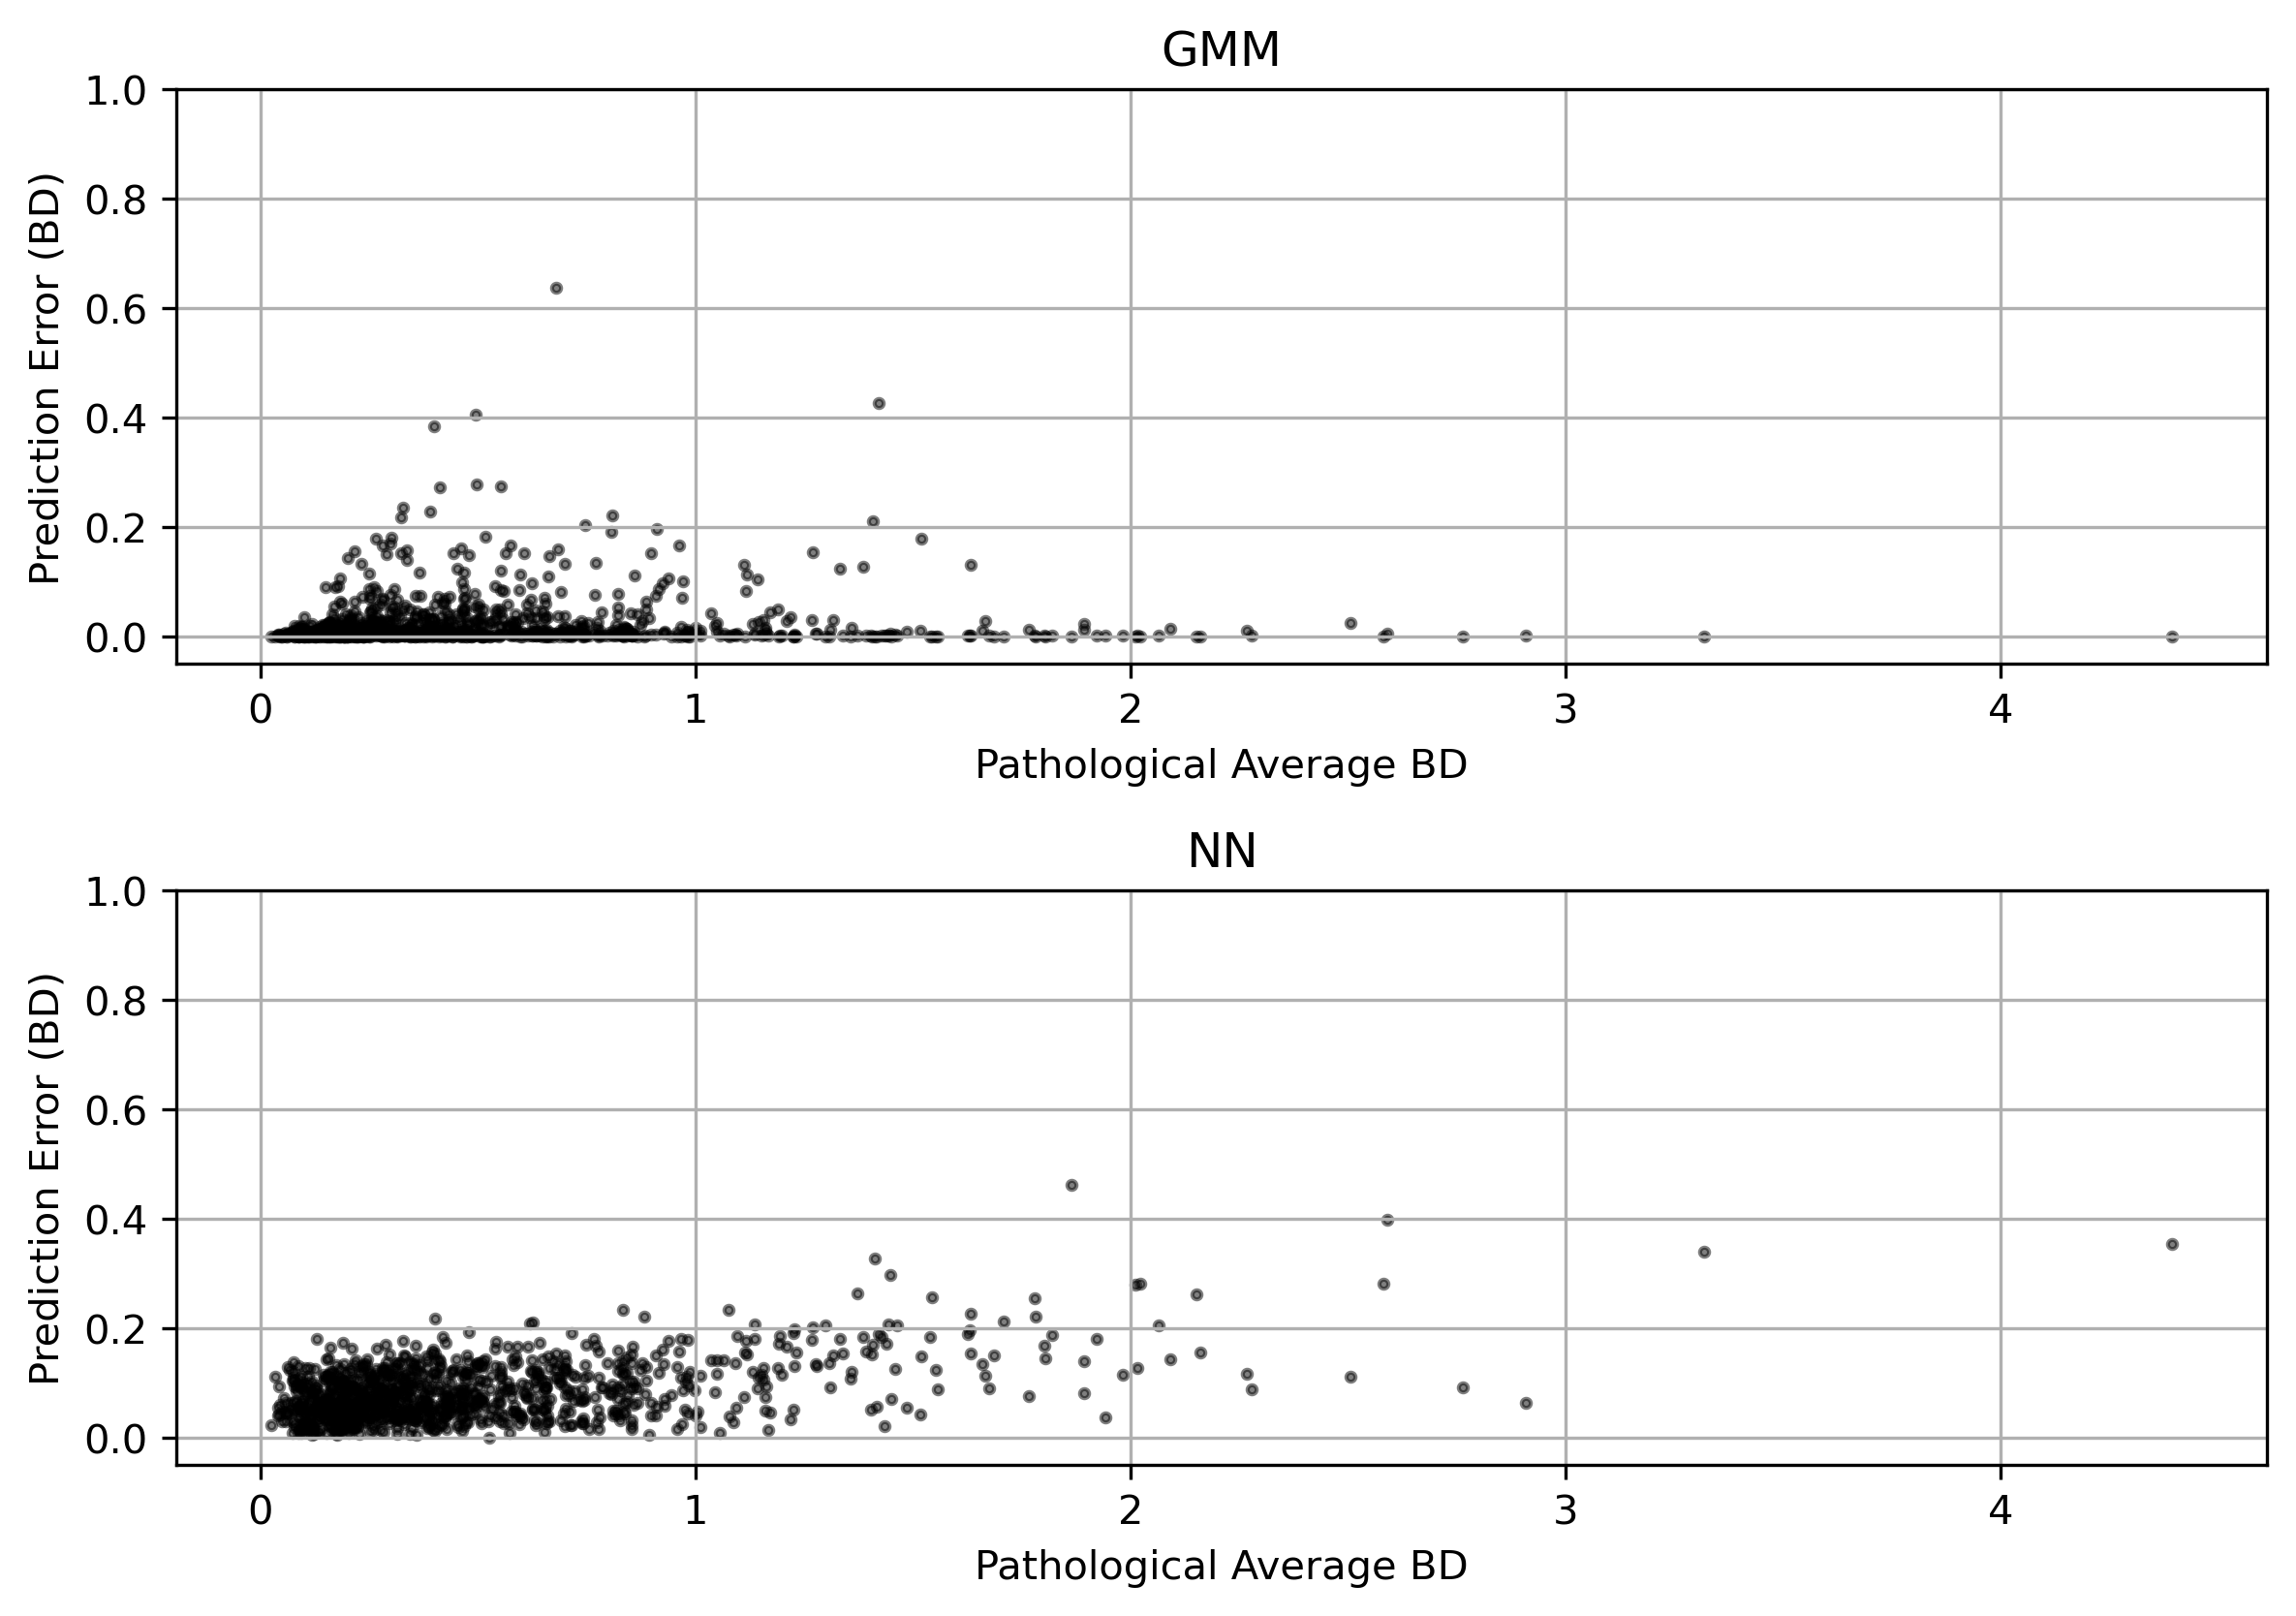

In [20]:
plt.figure(figsize=(8, 8), dpi=300)
for c,i in enumerate(['GMM', 'NN']):
    plt.subplot(3,1,c+1)
    plt.scatter(bd_dists, errors[i], s=5, c='k', alpha=0.5)
    plt.ylim([-0.05, 1.0])
    if i=='GMM':
        plt.title('GMM')
    else:
        plt.title(i)
    plt.grid()
    plt.ylabel('Prediction Error (BD)')
    plt.xlabel('Pathological Average BD')
plt.tight_layout()
